In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from sklearn.manifold import TSNE
from pytorch_metric_learning import losses, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [50]:
device = 'cpu'

In [51]:
class Net(nn.Module):
    def __init__(self, embedding_size=128, output_classes=10):
        super(Net, self).__init__()
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, embedding_size)
    
    def forward(self, x):
        x = self.cnn(x)
        return x

In [52]:
def cosine_similarity(embeddings1, embeddings2):
    embeddings1 = F.normalize(embeddings1, p=2, dim=1)
    embeddings2 = F.normalize(embeddings2, p=2, dim=1)
    return torch.mm(embeddings1, embeddings2.t())

def arcface_loss(cosine, target, m=0.4, output_classes=10):
    cosine = cosine.clip(-1+1e-7, 1-1e-7)
    arcosine = cosine.arccos()
    arcosine += F.one_hot(target, num_classes=output_classes) * m
    cosine2 = arcosine.cos()
    return F.cross_entropy(cosine2, target)

In [53]:
def train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        loss_optimizer.zero_grad()
        embeddings = model(data)
        loss = loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()
        loss_optimizer.step()
        if batch_idx % 100 == 0:
            print("Epoch {} Iteration {}: Loss = {}".format(epoch, batch_idx, loss))


def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, test_labels, train_embeddings, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))

In [78]:
def visualize_tsne(embeddings, labels):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings.cpu().numpy())
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels.cpu().numpy(), cmap='tab10', alpha=0.7)
    plt.colorbar(scatter)
    plt.title("t-SNE Visualization of Embeddings")
    plt.show()

def show_image_pairs_with_distance(dataset, model, num_pairs=5):
    model.eval()
    indices = np.random.choice(len(dataset), size=num_pairs*2, replace=False)
    pairs = [(dataset[i], dataset[j]) for i, j in zip(indices[:num_pairs], indices[num_pairs:])]
    
    fig, axes = plt.subplots(num_pairs, 2, figsize=(8, num_pairs*2))
    with torch.no_grad():
        for i, ((img1, label1), (img2, label2)) in enumerate(pairs):
            emb1 = model(img1.unsqueeze(0))
            emb2 = model(img2.unsqueeze(0))
            distance = F.pairwise_distance(emb1, emb2).item()
            
            axes[i, 0].imshow(img1.permute(1, 2, 0).cpu().numpy(), cmap='gray')
            axes[i, 1].imshow(img2.permute(1, 2, 0).cpu().numpy(), cmap='gray')
            axes[i, 0].axis('off')
            axes[i, 1].axis('off')
            axes[i, 1].set_title(f"Distance: {distance:.2f}")
    plt.show()

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()]
)

batch_size = 64

dataset = datasets.ImageFolder(root='images',
                                     transform=transform)
train_dataset, test_dataset = random_split(dataset=dataset,
                                           lengths=[0.7, 0.3])
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = Net()
for param in model.parameters():
  param.requires_grad = False
for param in model.cnn.fc.parameters():
  param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 1

loss_func = losses.ArcFaceLoss(num_classes=10, embedding_size=128).to(device)
loss_optimizer = torch.optim.Adam(loss_func.parameters(), lr=1e-4)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.13582934..2.8214867].


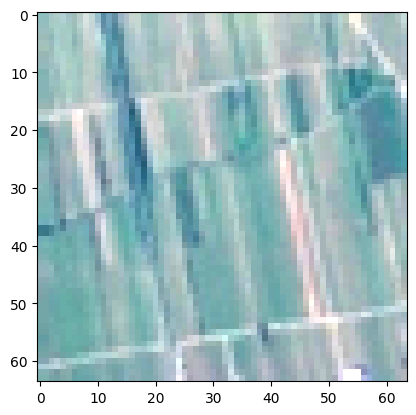

In [56]:
plt.imshow(train_loader.dataset[0][0].permute(1,2,0))

In [57]:
train_loader.dataset[0][0].shape

torch.Size([3, 64, 64])

In [58]:
for epoch in range(1, num_epochs + 1):
    train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch)
    test(train_dataset, test_dataset, model, accuracy_calculator)

Epoch 1 Iteration 0: Loss = 39.46673583984375
Epoch 1 Iteration 100: Loss = 14.705698013305664
Epoch 1 Iteration 200: Loss = 12.961488723754883


100%|██████████| 254/254 [00:41<00:00,  6.18it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8061728395061728


In [59]:
train_embeddings, train_labels = get_all_embeddings(train_dataset, model)

100%|██████████| 591/591 [00:46<00:00, 12.66it/s]


100%|██████████| 254/254 [00:28<00:00,  9.04it/s]


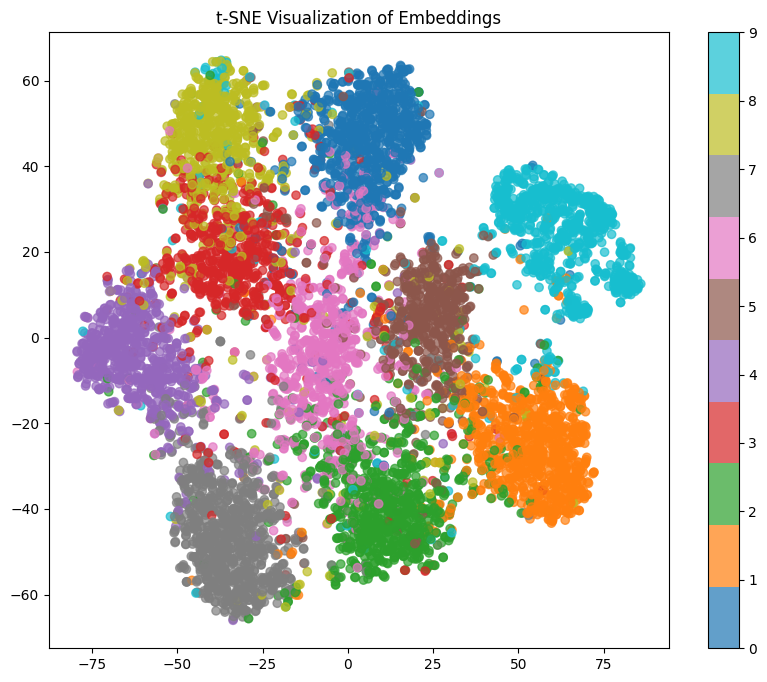

In [79]:
test_embeddings, test_labels = get_all_embeddings(test_dataset, model)
visualize_tsne(test_embeddings, test_labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09327888..2.4905527].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.16964827..0.64495873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05945994..2.4905527].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.016909458..0.7976975].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.02127524..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.33948106..1.7523152].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0

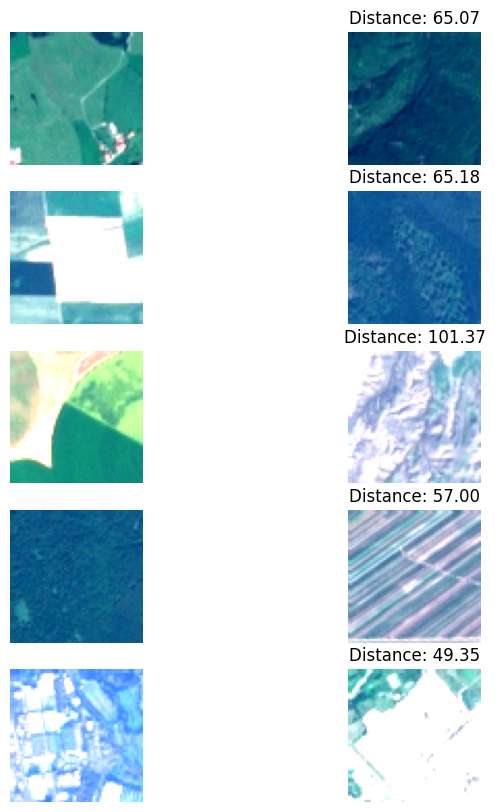

In [93]:
show_image_pairs_with_distance(test_dataset, model)